![alt text](http://www.kisbu.edu.tr/wp-content/uploads/2018/05/kharazmi.png)


![alt text](http://s9.picofile.com/file/8346800600/Untitled.png)
# Diabetic Retinopathy Detection by Convolutional Neural Network

using Keras Library (Tensorflow Backend)


Researchers:

***Ali Forghani ElahAbadi  ***

***Maryam Dorosti              ***

***Maryam Dolati                ***

***Khadijeh Hashemi          ***


DIP Workshop in Kharazmi University, 
Tehran, IRAN




[Preprocess Step Reference](https://github.com/usuyama/pydata-medical-image/blob/master/diabetic_retinopathy/notebooks/1_preprocess.ipynb)
---


# Step 1: PreConfiguration of Codes

## mount google drive for read the dataset retino images (train and test files)

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **import important library**

In [0]:
from IPython import get_ipython
get_ipython().magic('reset -sf')
import pandas as pd
from glob import glob
import os
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

np.random.seed(400)

## Set dataset path and filenames array

In [0]:
input_path = '/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/'
train_files_nosymptoms = glob(os.path.join(input_path, "nosymptoms", "*.jpeg"))
train_files_symptoms = glob(os.path.join(input_path, "symptoms", "*.jpeg"))

## show example image of retinopathy dataset

Not See symptoms of retinopathy


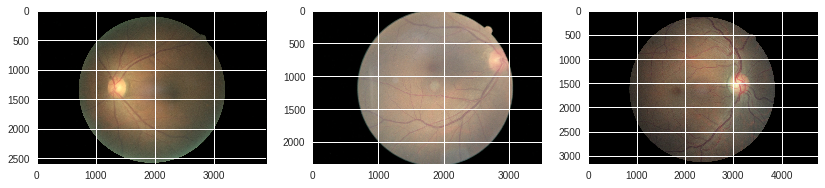

See symptoms of retinopathy


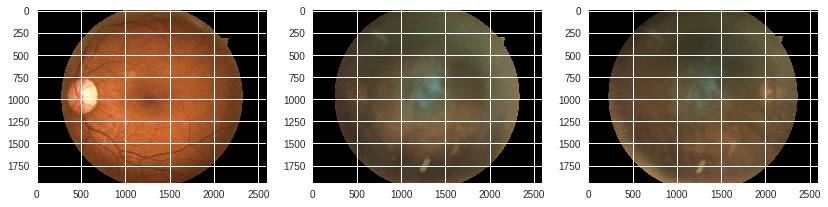

In [0]:

print('Not See symptoms of retinopathy')

image_sample_number = 3
plt.figure(figsize=(14, 10))
ncol = 3
nrow = 1

for i in range(0, image_sample_number):
    plt.subplot(nrow, ncol, i + 1)
    img = mpimg.imread(train_files_nosymptoms[i])
    plt.imshow(img)
    
plt.show()
    
print('See symptoms of retinopathy')

image_sample_number = 3
plt.figure(figsize=(14, 10))
ncol = 3
nrow = 1

for i in range(0, image_sample_number):
    plt.subplot(nrow, ncol, i + 1)
    img = mpimg.imread(train_files_symptoms[i])
    plt.imshow(img)
    
plt.show()

## Show example retino image and this shape 

/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/nosymptoms/16419_left.jpeg
(1920, 2560, 3)


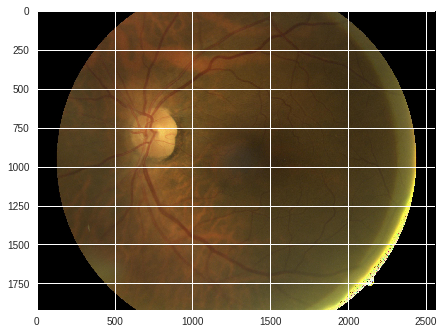

In [0]:
img_file = train_files_nosymptoms[6]
print(img_file)
img = mpimg.imread(img_file)
print(img.shape)
plt.imshow(img)

# Step 2: Preprocessing

## Estimate the Redius of Eyes

this part of code help us to estimate the radius of the eye with calculate sum of the rows and columns

In [0]:
def estimate_radius(img):
    mx = img[img.shape[0] // 2,:,:].sum(1)
    rx = (mx > mx.mean() / 10).sum() / 2
    
    my = img[:,img.shape[1] // 2,:].sum(1)
    ry = (my > my.mean() / 10).sum() / 2

    return (ry, rx)

ry, rx = estimate_radius(img)

(rx, ry)

(1155.0, 960.0)

## Image Scaling

In this part we resize the image with consider rx and ry And  we choice the minimum of value


(426, 567, 3)


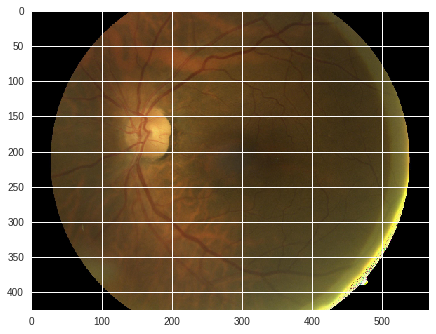

In [0]:
scale = 256
resize_scale = scale / max(rx, ry)
w = min(int(rx * resize_scale * 2), scale * 2)
h = min(int(ry * resize_scale * 2), scale * 2)
img_resize = cv2.resize(img.copy(), (0, 0), fx=resize_scale, fy=resize_scale)
print(img_resize.shape)
plt.imshow(img_resize)

## Image Cropping

In this part we crop the image to remove the extra part that has no useful information

425 512
(425, 512, 3)


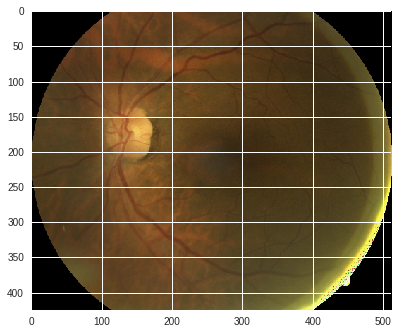

In [0]:
def crop_img(img, h, w):
    h_margin = (img.shape[0] - h) // 2 if img.shape[0] > h else 0
    w_margin = (img.shape[1] - w) // 2 if img.shape[1] > w else 0

    crop_img = img[h_margin:h + h_margin,w_margin:w + w_margin,:]

    return crop_img

print(h, w)
img_crop = crop_img(img_resize.copy(), h, w)
print(img_crop.shape)
plt.imshow(img_crop)

## Subtract Gaussian Blur


In this part we apply gaussian_blur to smooth the picture and Subtract the blured image and original  image to bold the vessels

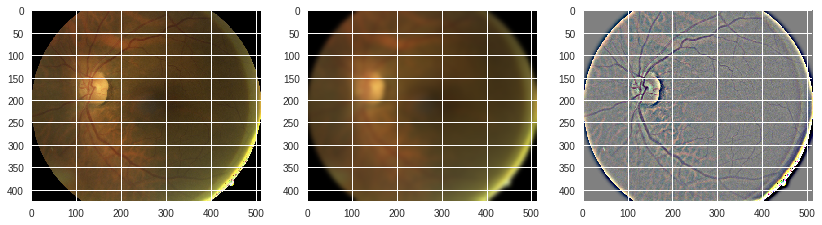

In [0]:
def subtract_gaussian_blur(img):
    # http://docs.opencv.org/trunk/d0/d86/tutorial_py_image_arithmetics.html
    # http://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html
    gb_img = cv2.GaussianBlur(img, (0, 0), 5)
    
    return cv2.addWeighted(img, 4, gb_img, -4, 128), gb_img
        
img_gbs, img_gb = subtract_gaussian_blur(img_crop.copy())
plt.figure(figsize=(14, 9))
plt.subplot(1, 3, 1)
plt.imshow(img_crop)
plt.subplot(1, 3, 2)
plt.imshow(img_gb)
plt.subplot(1, 3, 3)
plt.imshow(img_gbs)

## Remove Outer Circle

remove the boundary effect of Gaussian blur to make it clearly


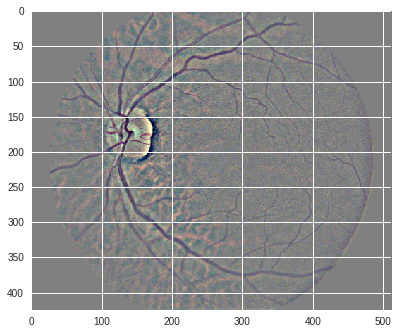

In [0]:
def remove_outer_circle(a, p, r):
    b = np.zeros(a.shape, dtype=np.uint8)
    cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(r * p), (1, 1, 1), -1, 8, 0)
    
    return a * b + 128 * (1 - b)

img_remove_outer = remove_outer_circle(img_gbs.copy(), 0.9, scale)
plt.imshow(img_remove_outer)

## Place the image in square


Place the processed image in the center of (512px, 512px) square

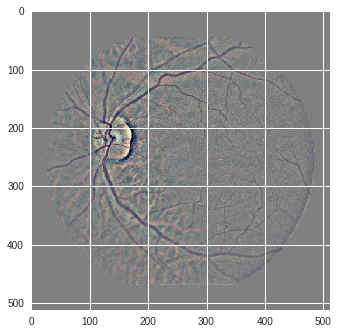

In [0]:
def place_in_square(img, r, h, w):
    new_img = np.zeros((2 * r, 2 * r, 3), dtype=np.uint8)
    new_img += 128
    new_img[r - h // 2:r - h // 2 + img.shape[0], r - w // 2:r - w // 2 + img.shape[1]] = img
    
    return new_img

new_img = place_in_square(img_remove_outer.copy(), scale, h, w)
plt.imshow(new_img)

## Preprocess all images

In [0]:
import math
cnt = 0
import os
for i in train_files_nosymptoms:
    if(cnt%100 == 0):
      print(str(math.floor((cnt/2081)*100)) + '% of preprocessing completed.')
    cnt += 1
    img = cv2.imread(i)
    ry, rx = estimate_radius(img)
    scale = 256
    resize_scale = scale / max(rx, ry)
    w = min(int(rx * resize_scale * 2), scale * 2)
    h = min(int(ry * resize_scale * 2), scale * 2)
    img_resize = cv2.resize(img.copy(), (0, 0), fx=resize_scale, fy=resize_scale)
    img_crop = crop_img(img_resize.copy(), h, w)
    img_gbs, img_gb = subtract_gaussian_blur(img_crop.copy())
    img_remove_outer = remove_outer_circle(img_gbs.copy(), 0.9, scale)
    new_img = place_in_square(img_remove_outer.copy(), scale, h, w)
    cv2.imwrite('/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/preprocess_images/' + i.split('/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/nosymptoms/')[1], new_img)
for i in train_files_symptoms:
    if(cnt%100 == 0):
      print(str(math.floor((cnt/2081)*100)) + '% of preprocessing completed.')
    cnt += 1
    img = cv2.imread(i)
    ry, rx = estimate_radius(img)
    scale = 256
    resize_scale = scale / max(rx, ry)
    w = min(int(rx * resize_scale * 2), scale * 2)
    h = min(int(ry * resize_scale * 2), scale * 2)
    img_resize = cv2.resize(img.copy(), (0, 0), fx=resize_scale, fy=resize_scale)
    img_crop = crop_img(img_resize.copy(), h, w)
    img_gbs, img_gb = subtract_gaussian_blur(img_crop.copy())
    img_remove_outer = remove_outer_circle(img_gbs.copy(), 0.9, scale)
    new_img = place_in_square(img_remove_outer.copy(), scale, h, w)
    cv2.imwrite('/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/preprocess_images/' + i.split('/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/symptoms/')[1], new_img)

print('preprocessing successful!')

0% of preprocessing completed.
4% of preprocessing completed.
9% of preprocessing completed.
14% of preprocessing completed.
19% of preprocessing completed.
24% of preprocessing completed.
28% of preprocessing completed.
33% of preprocessing completed.
38% of preprocessing completed.
43% of preprocessing completed.
48% of preprocessing completed.
52% of preprocessing completed.
57% of preprocessing completed.
62% of preprocessing completed.
67% of preprocessing completed.
72% of preprocessing completed.
76% of preprocessing completed.
81% of preprocessing completed.
86% of preprocessing completed.
91% of preprocessing completed.
96% of preprocessing completed.
preprocessing successful!


# Step 3: Data Configurations

## Set file path on preprocess images producted folder 

In [0]:
path = "/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master"
files = glob(os.path.join(path, "preprocess_images/*"))
print(len(files))

2081


## Create CSV Labels file

In [0]:
#create labels csv file and saving to google drive

label_list = []
for i in range(0, 1478):
  label_list.append(0)
for i in range(0, 603):
  label_list.append(1)
  
print(label_list)
print(len(label_list))

file_name1 =  glob("/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/nosymptoms/*")
for i in range(0, len(file_name1)):
  file_name1[i] = file_name1[i].split('/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/nosymptoms/')[1]

file_name2 =  glob("/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/symptoms/*")
for i in range(0, len(file_name2)):
  file_name2[i] = file_name2[i].split('/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/symptoms/')[1]

fn_list = []
for i in range(0, len(file_name1)):
  fn_list.append(file_name1[i])
for i in range(0, len(file_name2)):
  fn_list.append(file_name2[i])
  
  
raw_data = {'file_name': fn_list, 'labels': label_list}
df = pd.DataFrame(raw_data, columns = ['file_name', 'labels'])
df.to_csv('/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/labels.csv', index=False)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## read the csv label file and shufflling the rows

In [0]:
#read the csv labels file
from sklearn.utils import shuffle
labels = pd.read_csv('/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/labels.csv')
labels = shuffle(labels)

 
label_list = labels.iloc[:, 1:].values
print(label_list)

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]




---

## plot labels histogram 

(array([1478.,  603.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

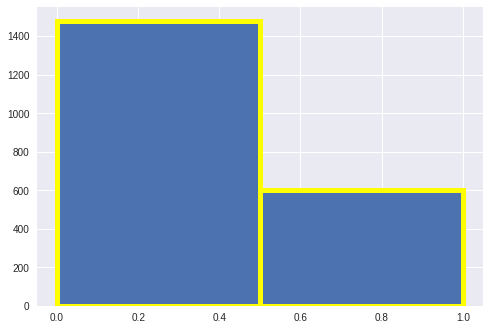

In [0]:

plt.hist(label_list, edgecolor='yellow', linewidth=5, bins=2)



## Load preprocess images on google colab

In [0]:
img_list = []
for i in range (0, len(labels['file_name'])):
  if(i%300 == 0):
    print(i / labels.shape[0])
  img = cv2.imread('/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/preprocess_images/' + labels['file_name'][i])
  img_list.append(np.asarray(img))

img_list = np.asarray(img_list)
print(img_list.shape)


0.0
0.14416146083613648
0.28832292167227297
0.4324843825084094
0.5766458433445459
0.7208073041806824
0.8649687650168189
(2081, 512, 512, 3)


## Train & Test Data Split

In [0]:
import math
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_list, label_list, test_size = 0.1, random_state = 0)

print('X Train:')
print(X_train.shape)
print('X Test:')
print(X_test.shape)
print('Y Train:')
print(y_train.shape)
print('Y Test:')
print(y_test.shape)

X Train:
(1872, 512, 512, 3)
X Test:
(209, 512, 512, 3)
Y Train:
(1872, 1)
Y Test:
(209, 1)


## Normalize the Data

In [0]:
#before normalize
print('before normalization:')
print('max:')
print(X_train.max())
print('min:')
print(X_train.min())

#normalize
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 
X_test /= 255

#after normalize
print('after normalization:')
print('max:')
print(X_train.max())
print('min:')
print(X_train.min())

before normalization:
max:
255
min:
0
after normalization:
max:
1.0
min:
0.0


## Step 4: Convolutional Neural Network Train , Test

## Import keras library

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers

Using TensorFlow backend.


## Network Model Definitions

**1. Convolution Activation Functions:**
the convolution activation function is** ELU** Because it has the ability to exert a negative effect during the learning process

RELU and ELU Difference:

*   ELU is very similiar to RELU except negative inputs
*   ELU is a smoothed version of the RELU in negative bound

![alt text](https://i0.wp.com/sefiks.com/wp-content/uploads/2018/01/elu-move1.png?resize=285%2C300&ssl=1)


![alt text](https://i0.wp.com/sefiks.com/wp-content/uploads/2018/01/elu-and-relu.png?resize=654%2C422&ssl=1)

**2. Convolution Padding:**
Same padding means the size of output feature-maps are the same as the input feature-maps . For instance, if input feature-maps of size 28×28, then in the output you expect to get feature maps of size 28×28 as well.
![alt text](https://qph.fs.quoracdn.net/main-qimg-9e3419cfcd8535fb289bb1b710920d2f)


**3.Batch Normalization:**
normalizes the activation of the previous layer at each batch, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.

**4.Flatten:**
Flattening is the process of converting all the resultant 2 dimensional arrays into a single long continuous linear vector.

**5.Max Pooling:**
Max pooling is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned

![alt text](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)
max pooling with 2*2 kernel

**6.Incremental Convolutions Number per Layers: **
in This model increment the number of Convolution in each layer because which looks that the deeper layer presents more details (as a result, need more filters) in this example picture.

**7.Kernel Initializer:**
Initialize the weights matrix by uniform Distribution

In [0]:
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import RMSprop

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='elu', input_shape=(512, 512, 3), 
                 padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='elu', padding = 'same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64 , (3, 3), activation='elu',  padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(64 , (3, 3), activation='elu',  padding = 'same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64, activation='relu', kernel_initializer='uniform', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))



model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 64)      18496     
__________

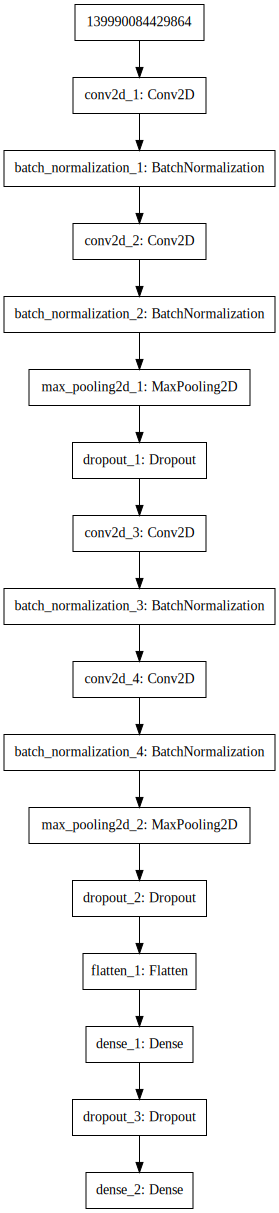

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/m.jpg', show_shapes=True, show_layer_names=True)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))


## Fit the network model 

In [0]:
history = model.fit(X_train, y_train, epochs = 4 ,batch_size = 8, shuffle = True, validation_split = 0.2, verbose = 1)


Train on 1497 samples, validate on 375 samples
Epoch 1/4
1497/1497 [==============================] - 120s 80ms/step - loss: 230.2378 - acc: 0.7034 - val_loss: 76.8710 - val_acc: 0.7120
Epoch 2/4
1497/1497 [==============================] - 106s 71ms/step - loss: 38.9543 - acc: 0.7121 - val_loss: 16.7071 - val_acc: 0.7120
Epoch 3/4
1497/1497 [==============================] - 106s 71ms/step - loss: 9.1793 - acc: 0.7121 - val_loss: 4.4779 - val_acc: 0.7120
Epoch 4/4
1497/1497 [==============================] - 107s 71ms/step - loss: 2.7308 - acc: 0.7121 - val_loss: 1.6071 - val_acc: 0.7120


## Model Evaluation

In [0]:
score = model.evaluate(X_test, y_test, verbose = 0)

print('Test Loss: ', score[0])
print('Test accuracy: ', score[1])


Test Loss:  1.6155725803101462
Test accuracy:  0.6937799060173582


In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


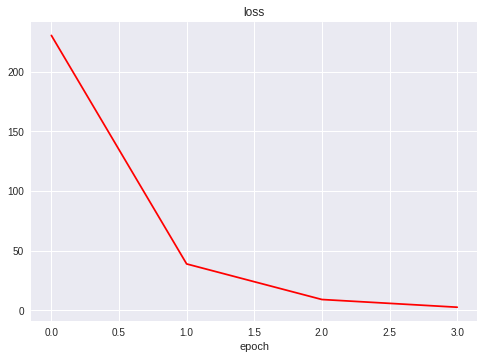

In [0]:

plt.plot(history.history['loss'], color = 'red')
plt.title('loss')
plt.xlabel('epoch')
plt.show()

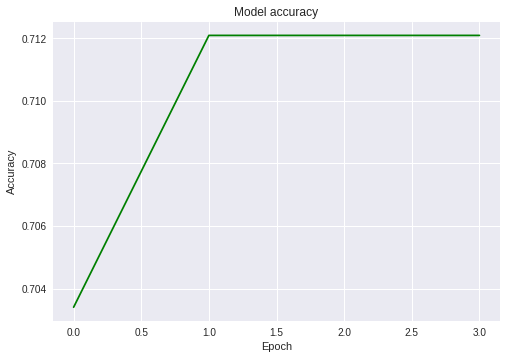

In [0]:
plt.plot(history.history['acc'], color = 'green')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Model Prediction

[0]
Diabetic Retinopathy not Detected!


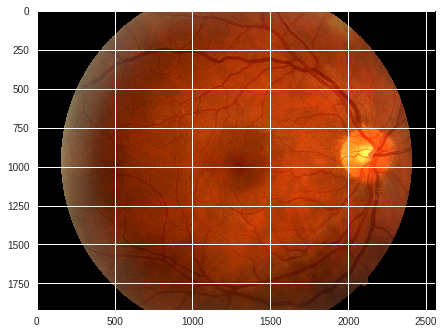

In [0]:
img = mpimg.imread('/content/drive/My Drive/Colab Notebooks/retinopathy-dataset-master/input_image.jpg')
plt.imshow(img)

ry, rx = estimate_radius(img)
scale = 256
resize_scale = scale / max(rx, ry)
w = min(int(rx * resize_scale * 2), scale * 2)
h = min(int(ry * resize_scale * 2), scale * 2)
img_resize = cv2.resize(img.copy(), (0, 0), fx=resize_scale, fy=resize_scale)
img_crop = crop_img(img_resize.copy(), h, w)
img_gbs, img_gb = subtract_gaussian_blur(img_crop.copy())
img_remove_outer = remove_outer_circle(img_gbs.copy(), 0.9, scale)
new_img = place_in_square(img_remove_outer.copy(), scale, h, w)
new_img = new_img.reshape(1, 512, 512, 3)
y_pred = model.predict_classes(new_img)
result = y_pred[0]
print(result)
if(result == [1]):
  print('Diabetic Retinopathy Detected!')
else:
  print('Diabetic Retinopathy not Detected!')